In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
import datetime, os
import tensorflow as tf
%load_ext tensorboard

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [3]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [4]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array, allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array,allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features,allow_pickle=True)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [5]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

In [6]:
len(features)

10222

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Label:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


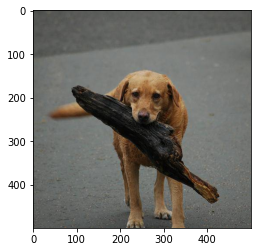

In [7]:
# Indice 4

print('Label: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)


### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [8]:
class claseKNN():
    def __init__(self, features, labels, k):
        # Parámetros
        self.features = features
        self.labels = labels
        self.k = k
        
    # Distancia manhattan
    def manhattanDist(self, X_train, X_test):
        return tf.reduce_sum(tf.abs(tf.subtract(X_train,X_test)), axis = 1)
    
    # Funcion para generar prediccion de raza de perro con k neighbors
    def predecir_raza_KNN(self, Y_train, X_train, X_test):
        
        with tf.name_scope("distance"):
            _, top_k_indices = tf.nn.top_k(tf.negative(self.manhattanDist(X_train, X_test)), k = self.k)
                
        #Indices mas comunes
        top_k_label = tf.gather(Y_train, top_k_indices)
        
        # Top de counts para cada uno de esos labels
        top_labels, _, top_counts = tf.unique_with_counts(top_k_label)
        
        # Encuentra el argmax de top_counts
        with tf.name_scope("ArgMax"):
            y = top_labels[tf.argmax(top_counts)]
        
        return y

In [13]:
def predice_raza(test_features, features, labels, k): #Quitar, distance_formula):
    # String para definicion de experimento
    string = './breedGraph/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    ClasificaKNN = claseKNN(features, labels, k)

    g = tf.Graph()
        
    with g.as_default():
        
        X_test = tf.placeholder(shape=[len(ClasificaKNN.features[0])], dtype=tf.float32, name ="x_test")
        X_train = tf.placeholder(shape=[None, len(ClasificaKNN.features[0])], dtype=tf.float32, name ="x_train")
        Y_train = tf.placeholder(shape=[len(ClasificaKNN.labels)], dtype=tf.string, name="y_train")
        
        # Prediccion segun el grafo definido
        prediccion = ClasificaKNN.predecir_raza_KNN(Y_train, X_train, X_test)
        
        # Graba el grafo
        writer = tf.summary.FileWriter(string, g)
        
        with tf.train.MonitoredSession() as session:
    
            feed_dict = {X_test: test_features, X_train: ClasificaKNN.features, Y_train: ClasificaKNN.labels}
                
            result = session.run(prediccion, feed_dict = feed_dict)
            
            return result

## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [14]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

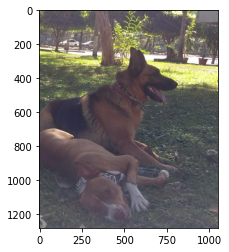

In [15]:
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)

In [16]:
predict_image = test_features[0]

## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd
predice_raza(predict_image, features, labels, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


b'german_shepherd'

### Prueba 2

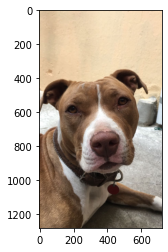

In [17]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)

In [18]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
predict_image = test_features[1]
predice_raza(predict_image, features, labels, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


b'american_staffordshire_terrier'

## Grafo

In [21]:
#logs_base_dir = "./breedGraph"
#os.makedirs(logs_base_dir, exist_ok=True)
#%load_ext tensorboard

In [23]:
#%tensorboard --logdir {logs_base_dir} --host=127.0.0.1 --port 6006 #./covidgr --port 6006
#%tensorboard dev upload --logdir \ './breedGraph' -h

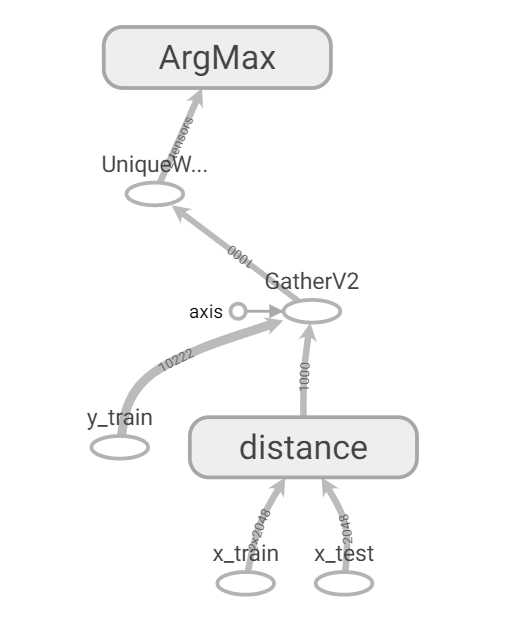